-


# Quick reminder of what the model looks like:

It is a heterogenous 2D areal (1-layer) model that is a step up in complexity from our xsec model. Recall it looks like this, as shown in the original Freyberg (1988) paper on the left, and a Groundwater Vistas version on the right (from the file in the GW_Vistas subdirectory).   

<img src="Freyburg1988_fig1.png" style="float: left">

<img src="Freyberg_k_plot_GW_Vistas.png" style="float: right">

### Standard two code blocks to set the notebook up

In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import pyemu

In [2]:
import freyberg_setup as fs
pst_name = fs.PST_NAME_KR
working_dir = fs.WORKING_DIR_KR
fs.setup_pest_kr()
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax = 0
pst.write(os.path.join(working_dir,pst_name))

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'obs_loc.csv', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_kr
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_k_and_r/freyberg_kr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY

### Let's run PESTCHEK and see what it says about our freyberg.pst file

In [3]:
pyemu.helpers.run("pestchek {0}".format(pst_name),cwd=working_dir)

run():pestchek freyberg_kr.pst


#### Curious, in the PESTCHEK warning section it says "All parameters belonging to the parameter group "rch" are either fixed or tied". That is flagged as a warning because PESTCHEK is wondering why would it not be adjustable after you went to all the trouble to define it as a parameter.  But, there  are times you may want to do this, so it is classified as a warning and isn't going to stop you.

### But that is not what we want, we want to make recharge a parameter in this activity.

### Open the PEST control file freyberg.pst in your text editor.  

1) Look in the parameter data section

2) Find the parameter __rch_0__ (the recharge for the calibration period) and make it adjustable (hint:  look at the other parameters) 

3) Save the file

4) Run PESTCHEK on the PEST control file in a seperate terminal window or by executing the next code block and looking at the terminal window where you launched this notebook

In [4]:
pyemu.helpers.run("pestchek {0}".format(pst_name),cwd=working_dir)

run():pestchek freyberg_kr.pst


Did that parameter group "rch" warning go away?


4) When no errors, run PEST++ by executing the next block (look in your terminal window to see the run progress and wait for the 0 to show up below the code block before continuing).


In [5]:
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

run():pestpp freyberg_kr.pst


Or...you can do this the boss way with pyemu...

In [6]:
pst.parameter_data.loc["rch_0","partrans"] = "none"
pst.write(os.path.join(working_dir,pst_name))

### ``PEST++`` only ran the model one time - why?

#### This was of course in the warnings when we ran PESTCHEK. Let's do that again in the next block and pay attention to that part of the warnings section (look at the terminal window where you launched this notebook to see the PESTCHEK output). 

In [7]:
pyemu.helpers.run("pestchek {0}".format(pst_name),cwd=working_dir)

run():pestchek freyberg_kr.pst


In [8]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax = 20
pst.write(os.path.join(working_dir,pst_name))

#### Let's run PESTCHEK again to make sure

In [9]:
pyemu.helpers.run("pestchek {0}".format(pst_name),cwd=working_dir)

run():pestchek freyberg_kr.pst


### Now that we've changed NOPTMAX, let's run a PEST++ again.  We set NOPTMAX to 20 so the run is longer - watch your terminal window for progress.  Again, don't advance until you see a 0 returned below the code block.


#### As you watch your terminal window scroll by, look at the right edge where it reports the counter of the runs needed for each PEST++ iteration.  Why does it change?

In [10]:
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

run():pestpp freyberg_kr.pst


### Let's see how we did for our fit:

In [11]:
df_obj = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".iobj")),index_col=0)
df_obj

,model_runs_completed,total_phi,measurement_phi,regularization_phi,flx_recharg,flx_constan,calhead,calflux,foretrav,vol_in-out,...,flx_storage,vol_recharg,flx_in-out,vol_percent,vol_river_l,flx_percent,forehead,flx_total,head,foreflux
iteration,,,,,,,,,,,,,,,,,,,,,
0,0,1322.400,1322.400,0,0,0,1322.400,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,1025.310,1025.310,0,0,0,1025.310,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,17,777.605,777.605,0,0,0,777.605,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,25,777.605,777.605,0,0,0,777.605,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,35,777.605,777.605,0,0,0,777.605,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(you can see this information unformatted by opening the .iobj file, which is a comma delimited ASCII PEST++ output file)



### Additional knobs given to PEST gives it more flexibility for fitting the observed data - is the final Phi lower than the last activity?


### You can see individual residuals (and the weights you specified) in the freyberg.rei file.  Here's we'll use Python to calculate the summary statistics for this new run:

In [12]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.phi

777.6053188131066

In [13]:
pst.phi_components

{'calflux': 0.0,
 'calhead': 777.6053188131066,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_river_l': 0.0,
 'flx_storage': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'foreflux': 0.0,
 'forehead': 0.0,
 'foretrav': 0.0,
 'head': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_river_l': 0.0,
 'vol_storage': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

In [14]:
pst.res.loc[pst.nnz_obs_names,:]

,name,group,measured,modelled,residual,weight
name,,,,,,
cr03c10_19700102,cr03c10_19700102,calhead,22.331451,23.649137,-1.317686,5.0
cr03c16_19700102,cr03c16_19700102,calhead,18.526869,19.906769,-1.379900,5.0
cr04c09_19700102,cr04c09_19700102,calhead,24.412637,24.397163,0.015473,5.0
cr10c02_19700102,cr10c02_19700102,calhead,27.985834,29.577051,-1.591217,5.0
cr14c11_19700102,cr14c11_19700102,calhead,21.070509,18.828060,2.242448,5.0
cr16c17_19700102,cr16c17_19700102,calhead,15.468176,17.452959,-1.984783,5.0
cr22c11_19700102,cr22c11_19700102,calhead,20.485881,17.817928,2.667953,5.0
cr23c16_19700102,cr23c16_19700102,calhead,15.308345,15.604322,-0.295977,5.0
cr25c05_19700102,cr25c05_19700102,calhead,22.408501,23.047710,-0.639209,5.0


(11.326556562029246, 30.357779944647184)

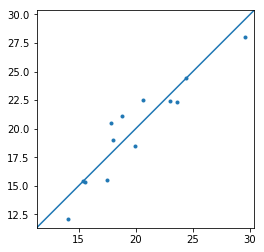

In [15]:
ax = plt.subplot(111,aspect="equal")                                               
ax.scatter(pst.res.loc[pst.nnz_obs_names,"modelled"],pst.res.loc[pst.nnz_obs_names,"measured"],marker='.')
ylim,xlim = ax.get_ylim(),ax.get_xlim()
mn = min(ylim[0],xlim[0])
mx = max(ylim[1],xlim[1])
ax.plot([mn,mx],[mn,mx])
ax.set_ylim(mn,mx)
ax.set_xlim(mn,mx)

### Hmm, looks familiar.....let's look at the parameter uncertainties:

In [16]:
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
df_paru

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
RCH_0,1.00000,0.125,0.75000,1.25000,1.250000,0.124082,1.001840,1.49816
HK,0.69897,0.500,-0.30103,1.69897,0.930811,0.068374,0.794064,1.06756


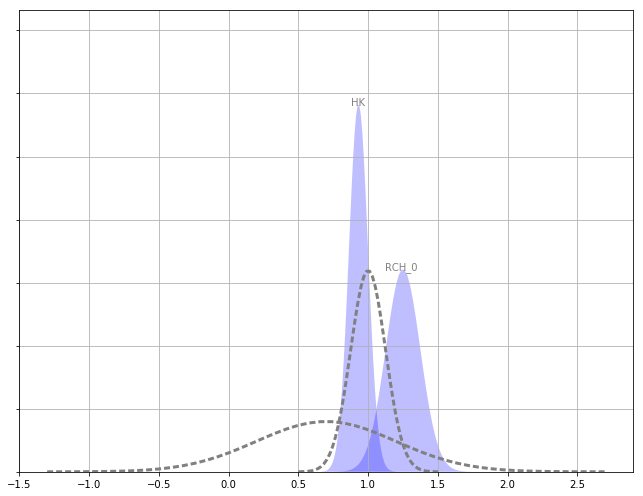

In [17]:
pyemu.helpers.plot_summary_distributions(df_paru,label_post=True)

### Now let's look at the parameter uncertainties:

#### Here's the K only case from the last activity:

In [18]:
df_paru_single = pd.read_csv(os.path.join("..","freyberg_k","freyberg_un","freyberg_un.par.usum.csv"),index_col=0)
df_paru_single

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
HK,0.69897,0.5,-0.30103,1.69897,0.833626,0.052271,0.729085,0.938167


#### Here's the new K+R (left) next the to K only results (right)

In [19]:
df_paru_concat = pd.concat([df_paru,df_paru_single],join="outer",axis=1,keys=["k+r","k_only"])
df_paru_concat.sort_index(inplace=True,axis=1)
#df_paru_concat.sort_index(level=1,inplace=True)

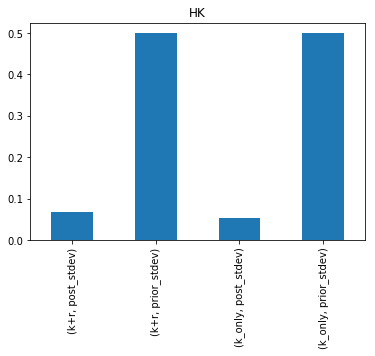

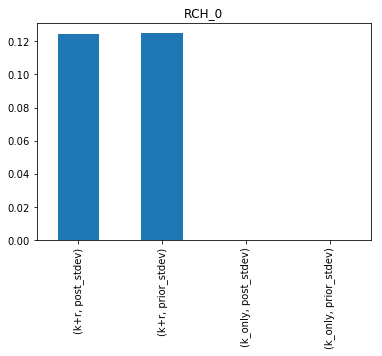

In [20]:
for pname in df_paru_concat.index:
    ax = df_paru_concat.loc[pname,(slice(None),("prior_stdev","post_stdev"))].plot(kind="bar")
    ax.set_title(pname)
    plt.show()

### How does the uncertainty reduction for ``hk`` change when ``rch_0`` is included?

## Now let's look at the forecasts:

#### First, here's our previous results for the K only case:

In [21]:
df_predu_single = pd.read_csv(os.path.join("..","freyberg_k","freyberg_un","freyberg_un.pred.usum.csv"),index_col=0)
df_predu_single.loc[:,"reduction"] = 100.0 *  (1.0 - (df_predu_single.post_stdev / df_predu_single.prior_stdev))

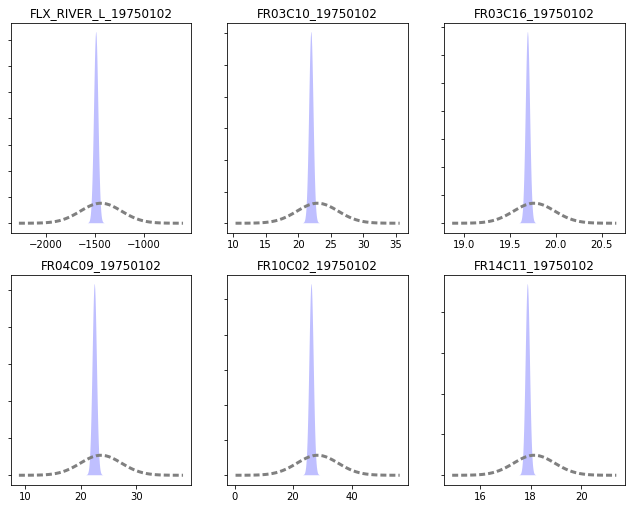

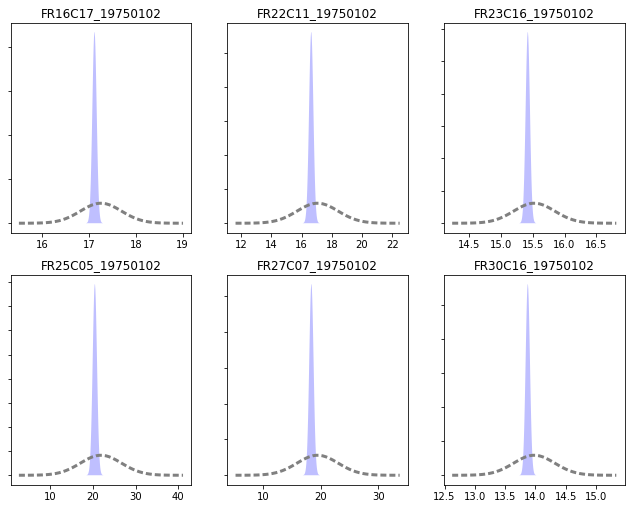

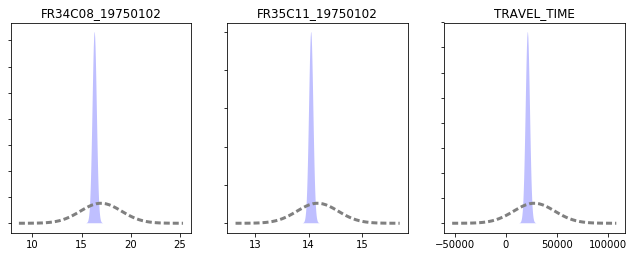

In [22]:
figs, axes = pyemu.helpers.plot_summary_distributions(df_predu_single,subplots=True)

#### Here's our new run where K and R are parameters:

In [23]:
df_predu = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".pred.usum.csv")),index_col=0)
df_predu.loc[:,"reduction"] = 100.0 *  (1.0 - (df_predu.post_stdev / df_predu.prior_stdev))

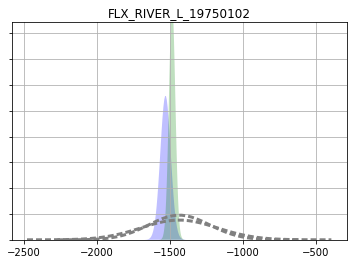

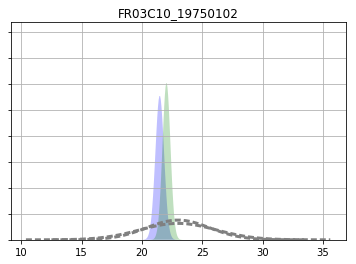

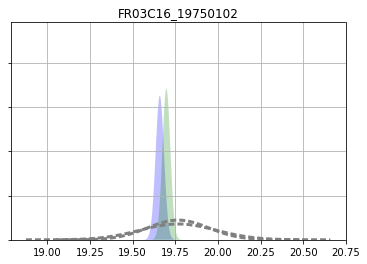

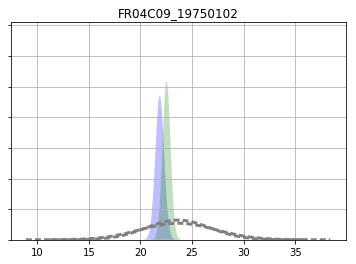

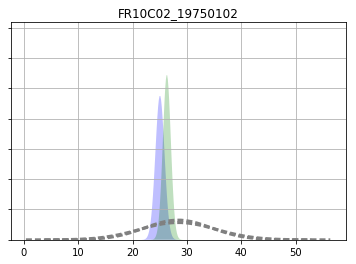

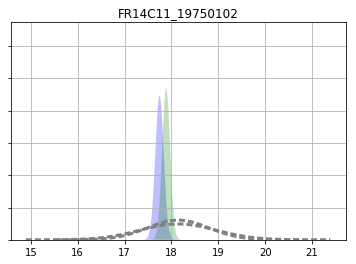

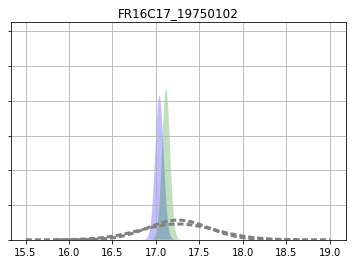

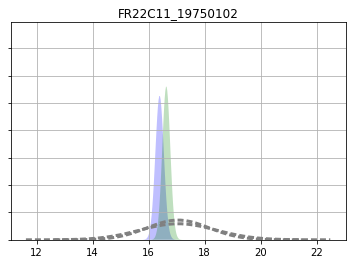

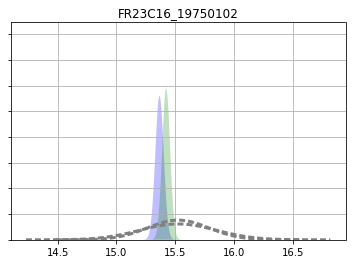

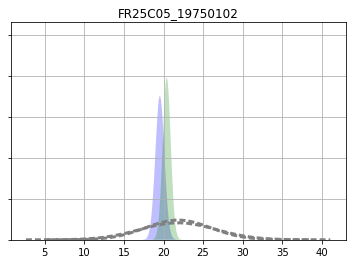

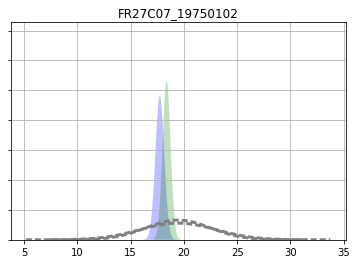

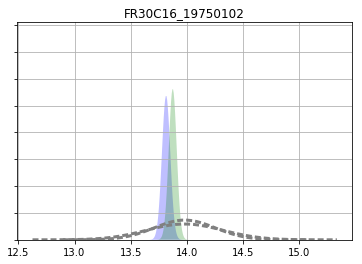

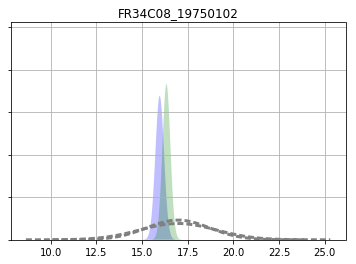

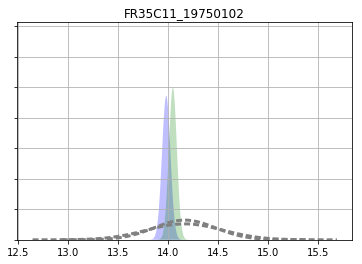

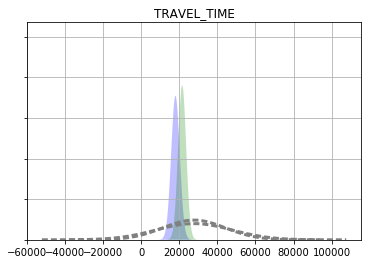

In [24]:
for forecast in df_predu.index:
    ax = plt.subplot(111)
    pyemu.helpers.plot_summary_distributions(df_predu.loc[[forecast],:],ax=ax)
    pyemu.helpers.plot_summary_distributions(df_predu_single.loc[[forecast],:],ax=ax,pt_color='g')
    ax.set_title(forecast)
    ax.grid()
    plt.show()

### Which forecasts are influenced by the ``rch_0`` parameter?  

### Which forecasts were more or less unchanged - why?

### Which case (``K`` or ``K+R``) provides the more robust uncertainty estimate?

# Wait, something is amiss.  

### Look at this slightly modified version of the groundwater governing equation from Anderson et al. (2015) below.  Is this problem well posed? That is, if recharge increased (represented by an increase in $W^*$) *and* at the same time K increased (represented by an increase in q) could they offset each other so that the righthand side stays the same? What is this called?

 
  <img src="GW_GE2.jpg" style="float: center">
 
 
 ### Recall the Bravo et al. (2002) trough when calibrating K and R with only heads:
 
  <img src="Fig9.11a_bravo_trough.jpeg" style="float: center">
  
  ****************
 

###  Even though estimating both R and K using only head observations is not possible, PEST++ gave you an answer.  How? (Hint:  look in the .rec file and see what happens to the parameters over the course of the run)


## Let's dig into the PEST result a bit more...

1) Compare the optimal rch1 parameter value in the __freyberg.rec__ file (search for "Optimal parameter values" without the quotation marks) to the rch1 parameter data the instructors supplied in the PEST control file.  

2) Where does the optimal parameter lie with respect to the bounds that were given for the parameter? 

3) Open the __freyberg.ipar__ file in a text editor.  What was the iteration history of rch1?

# Let's look at the correlation

In [25]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace(".pst",".jcb")))
cov = pyemu.Cov(sc.xtqx.x, names=sc.pst.adj_par_names)
R = cov.to_pearson()
R.df()

,rch_0,hk
rch_0,1.000000,-0.996627
hk,-0.996627,1.000000


# Let's test how "optimal" these parameters are. 

1) Open freyberg_kr\freyberg_kr.pst in a text editor, 

2) change the upper bound of the rch_0 parameter from 1.5500000000E-04 to 2.5500000000E-04

3) re-run pestpp

4) open the __freyberg_kr.ipar__ file in a text editor.  

# Last points:

## Do you believe that value is optimal, or even defensible?  Should we believe the forecast uncertainty either?

Let's again look at the forecasts with the "Truth"

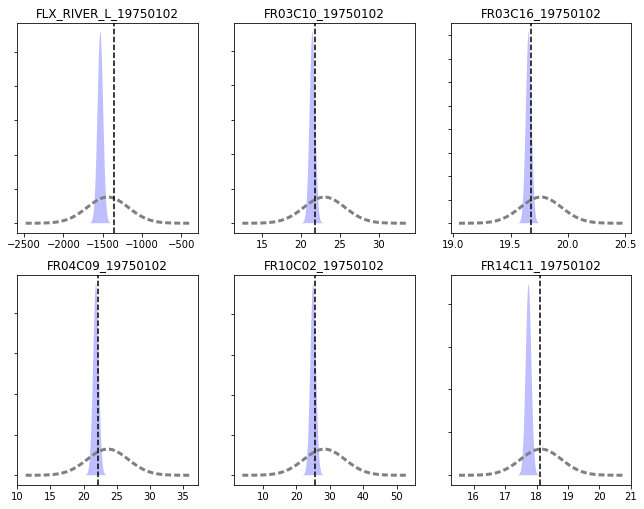

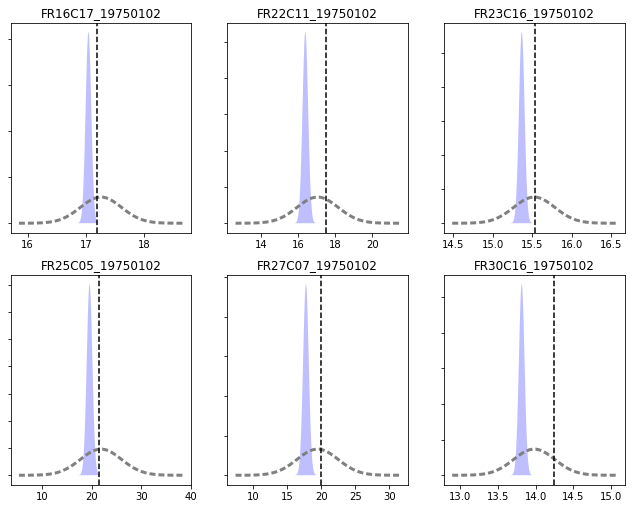

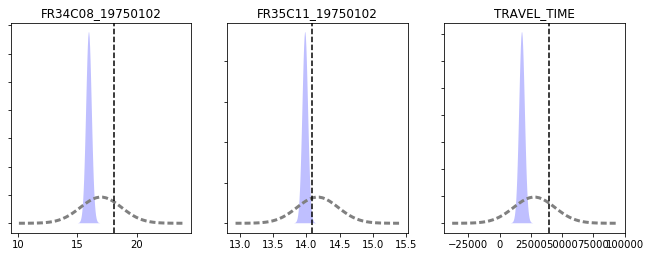

In [26]:
figs, axes = pyemu.helpers.plot_summary_distributions(df_predu,subplots=True)
for ax in axes:
    fname = ax.get_title().lower()
    ylim = ax.get_ylim()
    v = pst.observation_data.loc[fname,"obsval"]
    ax.plot([v,v],ylim,"k--")
    ax.set_ylim(ylim)

Still not bracketing the "truth" for many forecasts...yikes!